<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091 entries, 0 to 1090
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   hours_studied              1091 non-null   float64
 1   attendance_rate            1091 non-null   float64
 2   homework_score             1091 non-null   float64
 3   test_score                 1091 non-null   float64
 4   class_participation        1091 non-null   float64
 5   study_group_participation  1091 non-null   int64  
 6   previous_grade             1091 non-null   float64
 7   sleep_hours                1091 non-null   float64
 8   age                        1091 non-null   int64  
 9   gender                     1091 non-null   object 
 10  favorite_subject           1091 non-null   object 
 11  final_grade                1091 non-null   float64
dtypes: float64(8), int64(2), object(2)
memory usage: 102.4+ KB
Outlier summary by column:
 hours_studied    

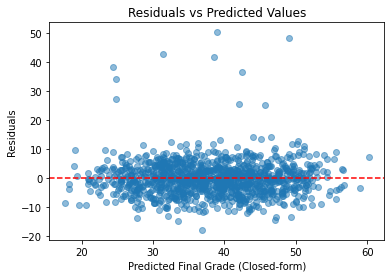

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


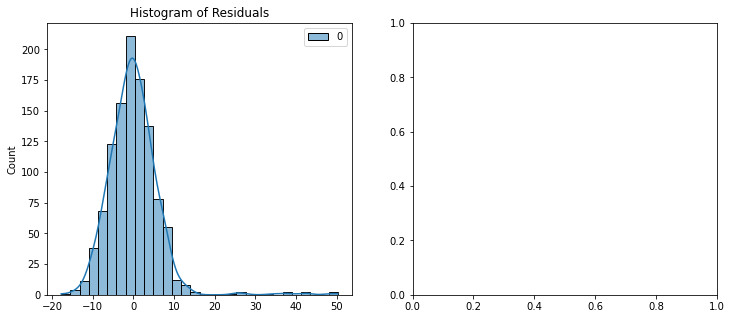

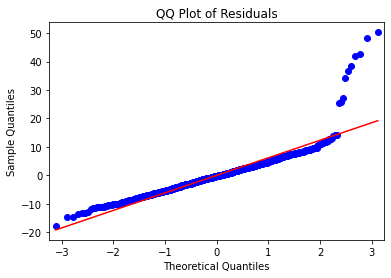


Normality test results:
Shapiro-Wilk Test: ShapiroResult(statistic=0.8642616271972656, pvalue=1.0853000422610951e-29)
Kolmogorov-Smirnov Test: KstestResult(statistic=0.34123496748451454, pvalue=6.773931225381751e-114)
D'Agostino's K-squared Test: NormaltestResult(statistic=array([608.28734233]), pvalue=array([8.16736391e-133]))


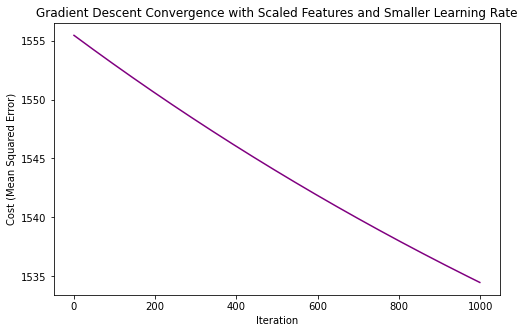


Gradient Descent coefficients:
 [ 1.45719861e-01  4.19935945e-01  1.10237703e+00  5.58702682e-01
  5.95795251e-01 -6.95149728e-03  2.64117637e-02 -2.02049341e-02
 -4.55080775e-02 -2.40125608e-04  6.29747651e-03 -8.17724888e-02
  4.20355285e-02  0.00000000e+00]

Ridge Regression Model Performance:
R-squared: 0.688070624958557
Mean Absolute Error (MAE): 4.128416072353532
Mean Squared Error (MSE): 26.72973307170948


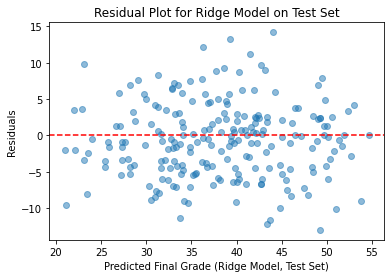

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, shapiro, kstest, normaltest
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import numpy.linalg as la

# Load the dataset
#file_path = 'C:\Users\DELL\student_grades.csv'
student_data = pd.read_csv('student_grades.csv')

#The dataset has 1091 entries(rows) and 12 columns. It has both numerical predictors like hours_studied and attendance_rate while it also has categorical predictors like gender and favourite subject. The target variable final_grade represents the final marks of the students.
#Their is no missing data 
student_data.head()
student_data.info()

#To separate the features and target variable
x = student_data.drop(columns=['final_grade'])
y = student_data['final_grade']

#Now using One-hot encode for categorical variables as only row columns have categorical data and now they are coverted
x_encoded_data = pd.get_dummies(x, columns=['gender', 'favorite_subject'], drop_first=True)

#Now to check for outliers by calculating the scores
numeric_cols_data = x_encoded_data.select_dtypes(include=np.number).columns
z_scores_val = np.abs(zscore(x_encoded_data[numeric_cols_data]))
outliers_no = np.where(z_scores_val > 3, True, False)#If zscore is greater than 3 then its an outlier
outlier_sum_data = pd.DataFrame(outliers_no, columns=numeric_cols_data).sum()
print("Outlier summary by column:\n", outlier_sum_data)

#Hence we can coclude their is no significant outlier in the dataset

#Closed-form linear regression whuch we can use as the dataset is relatively small and it does not have a high no of features becasue this involves matrix inversion
x_encoded_data['bias'] = 1 #we are adding a column bias with value 1 to each row in x_encoded_data to get intercept term
x_matrix_data = x_encoded_data.values #to convert the data to matrix form
y_matrix_data = y.values.reshape(-1, 1) #to convert the target variable y to column vector and get the correct dimensions

theta_closed_form_lin_reg = la.inv(x_matrix_data.T @ x_matrix_data) @ x_matrix_data.T @ y_matrix_data #now perfroming matrix multiplication of the transpose matrix
#print("\nClosed-form solution coefficients:\n", theta_closed_form_lin_reg.flatten())

feature_names_list = x_encoded_data.columns.tolist()
coeff_data = theta_closed_form_lin_reg.flatten()


# Sort by absolute value of coefficients to find the most impactful features
ft_imp = sorted(zip(feature_names_list, coeff_data), key=lambda x: abs(x[1]), reverse=True)
print()
print("\nClosed-form solution coefficients:\n",ft_imp)


# Predictions and residuals for assumption checking
y_predic_cl_fm = x_matrix_data @ theta_closed_form_lin_reg
res = y_matrix_data - y_predic_cl_fm

# Linearity assumption check
plt.figure(figsize=(6, 4))
plt.scatter(y_predic_cl_fm, res, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Final Grade (Closed-form)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

# Normality of residuals: Histogram and QQ plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(res, kde=True, bins=30)
plt.title("Histogram of Residuals")

plt.subplot(1, 2, 2)
sm.qqplot(res.flatten(), line='s')
plt.title("QQ Plot of Residuals")
plt.show()

# Normality tests
shap_tt = shapiro(res)
kstest_tt = kstest(res.flatten(), 'norm')
nml_tt = normaltest(res)
print("\nNormality test results:")
print("Shapiro-Wilk Test:", shap_tt)
print("Kolmogorov-Smirnov Test:", kstest_tt)
print("D'Agostino's K-squared Test:", nml_tt)

# Gradient Descent Implementation
def grad_desct(x, y, lr=0.01, iterations=1000):
    m, n = x.shape
    theta = np.zeros((n, 1))
    c_hist = []
    for i in range(iterations):
        grad = (2 / m) * x.T @ (x @ theta - y)
        theta -= lr * grad
        cost = np.mean((x @ theta - y) ** 2)
        c_hist.append(cost)
    return theta, c_hist

# Scaling features for stable gradient descent
scaler = StandardScaler()
x_sc = scaler.fit_transform(x_matrix_data)

# Gradient descent with scaled features and a small learning rate
theta_gd_scaled, cost_history_scaled = grad_desct(x_sc, y_matrix_data, lr=0.0001, iterations=1000)

# Plotting gradient descent convergence
plt.figure(figsize=(8, 5))
plt.plot(range(len(cost_history_scaled)), cost_history_scaled, color='purple')
plt.xlabel("Iteration")
plt.ylabel("Cost (Mean Squared Error)")
plt.title("Gradient Descent Convergence with Scaled Features and Smaller Learning Rate")
plt.show()

print("\nGradient Descent coefficients:\n", theta_gd_scaled.flatten())

# Train-Test Split and Model Evaluation with Ridge Regression
x_tr, x_tt, y_tr, y_tt = train_test_split(x_sc, y_matrix_data, test_size=0.2, random_state=42)

rd_mod = Ridge(alpha=0.1)
rd_mod.fit(x_tr, y_tr)
y_pred_ridge = rd_mod.predict(x_tt)

# Evaluation metrics
r2_ridge = r2_score(y_tt, y_pred_ridge)
mae_ridge = mean_absolute_error(y_tt, y_pred_ridge)
mse_ridge = mean_squared_error(y_tt, y_pred_ridge)

print("\nRidge Regression Model Performance:")
print("R-squared:", r2_ridge)
print("Mean Absolute Error (MAE):", mae_ridge)
print("Mean Squared Error (MSE):", mse_ridge)

# Residual plot for Ridge regression
ridge_residuals = y_tt - y_pred_ridge
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_ridge, ridge_residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Final Grade (Ridge Model, Test Set)")
plt.ylabel("Residuals")
plt.title("Residual Plot for Ridge Model on Test Set")
plt.show()


Optimized Coefficients: [ 2.18261714  0.43710893  0.12142751 -0.01091688  0.03481762  0.2944919 ]
Model Evaluation Metrics:
Accuracy: 0.9180327868852459
Precision: 0.9180327868852459
Recall: 1.0
ROC-AUC: 0.6214285714285716


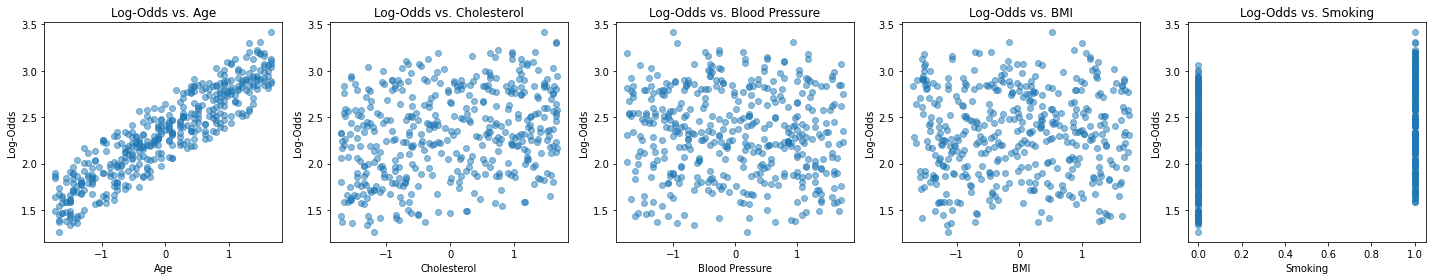

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from scipy.optimize import minimize

# Load the dataset
dt_set = pd.read_csv('heart_disease_data.csv')

# Separate features and target, creating a copy to avoid SettingWithCopyWarning
X = dt_set[['Age', 'Cholesterol', 'Blood Pressure', 'BMI', 'Smoking']].copy()
y = dt_set['Diagnosis']

# Normalize continuous features
scaler = StandardScaler()
X[['Age', 'Cholesterol', 'Blood Pressure', 'BMI']] = scaler.fit_transform(X[['Age', 'Cholesterol', 'Blood Pressure', 'BMI']])

# Split data into training and test sets
X_tr, X_tt, y_tr, y_tt = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the sigmoid function
def sigm(z):
    return 1 / (1 + np.exp(-z))

# Define the cost function for logistic regression (negative log-likelihood)
def ct_func(theta, X, y):
    m = len(y)
    h = sigm(X @ theta)
    epsi = 1e-5  # Small value to avoid log(0)
    ct = -1/m * (y.T @ np.log(h + epsi) + (1 - y).T @ np.log(1 - h + epsi))
    return ct

# Define the gradient for logistic regression
def grad(theta, X, y):
    m = len(y)
    h = sigm(X @ theta)
    return (1/m) * (X.T @ (h - y))

# Add intercept term to X
X_tr_inter = np.hstack((np.ones((X_tr.shape[0], 1)), X_tr))
X_tt_inter = np.hstack((np.ones((X_tt.shape[0], 1)), X_tt))

# Initial theta values
ini_theta = np.zeros(X_tr_inter.shape[1])

# Perform optimization to find the best parameters
fin_out = minimize(fun=ct_func, x0=ini_theta, args=(X_tr_inter, y_tr), method='BFGS', jac=grad)

# Extract optimized theta
opt_theta = fin_out.x

# Predict probabilities on the test set
y_pred_prob = sigm(X_tt_inter @ opt_theta)

# Convert probabilities to binary predictions with a threshold of 0.5
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_tt, y_pred)
precision = precision_score(y_tt, y_pred)
recall = recall_score(y_tt, y_pred)
roc_auc = roc_auc_score(y_tt, y_pred_prob)

# Print results
print("Optimized Coefficients:", opt_theta)
print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC-AUC:", roc_auc)

# Test Linearity in Log-Odds by plotting each feature against the log-odds
# Calculate log-odds for the test set
log_odds = X_tt_inter @ opt_theta

# Plot log-odds against each feature
features = ['Age', 'Cholesterol', 'Blood Pressure', 'BMI', 'Smoking']
fig, axes = plt.subplots(1, len(features), figsize=(20, 4))

for i, feature in enumerate(features):
    axes[i].scatter(X_tt[feature], log_odds, alpha=0.5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Log-Odds")
    axes[i].set_title(f"Log-Odds vs. {feature}")

plt.tight_layout()
plt.show()


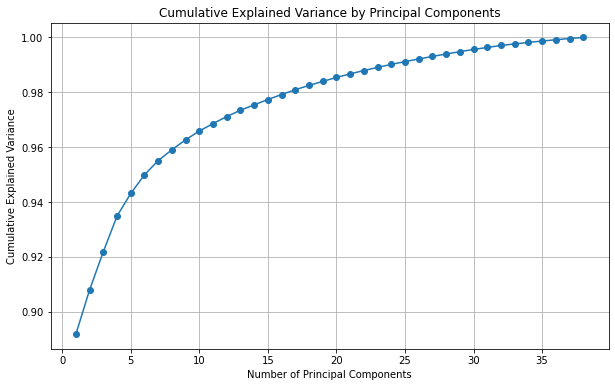

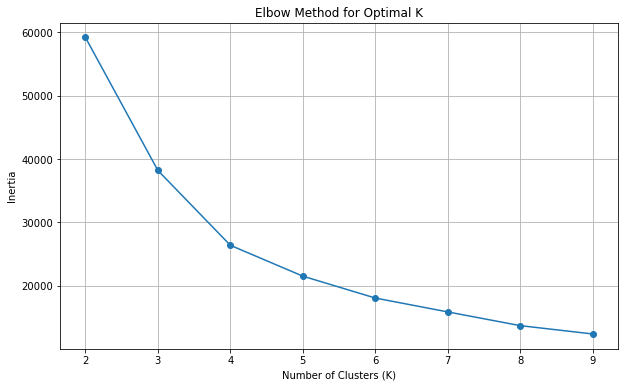

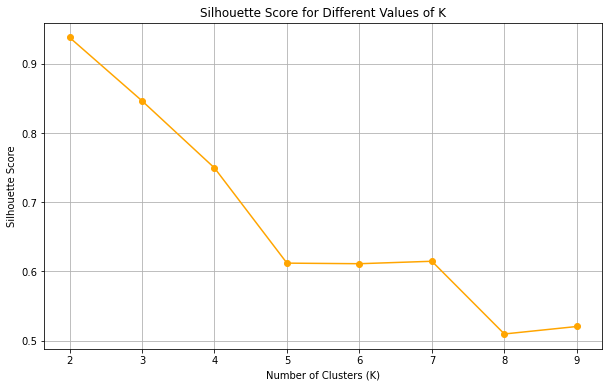

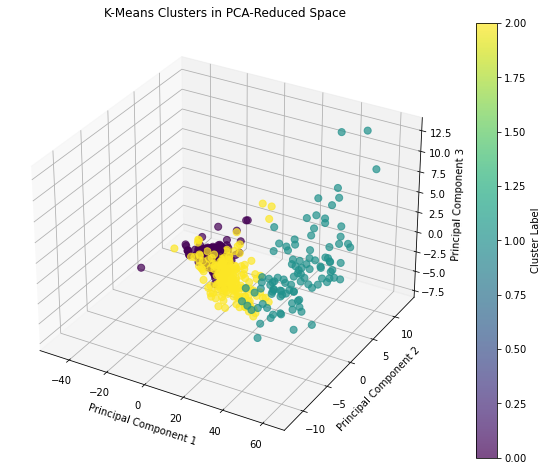

In [9]:
# Step 1: Import libraries and load the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset

dt_set = pd.read_csv('data_set_ALL_AML_train.csv')

# Drop non-numeric columns: 'Gene Description', 'Gene Accession Number' and all 'call' columns
dt_clean = dt_set.drop(columns=['Gene Description', 'Gene Accession Number'] + [col for col in dt_set.columns if 'call' in col])

# Convert data to numeric, dropping any rows that may contain non-numeric entries
dt_clean = dt_clean.apply(pd.to_numeric, errors='coerce').dropna()

# Step 2: Standardize the data
scaler = StandardScaler()
dt_stand = scaler.fit_transform(dt_clean)

# Step 3: Perform PCA
# Initialize PCA and fit it to the standardized data
pca = PCA()
pca.fit(dt_stand)

# Explained variance ratio for each component
exp_var_rt = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cum_var = np.cumsum(exp_var_rt)

# Plot cumulative explained variance to decide the number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid()
plt.show()

# Select top 3 components based on the plot
pca_red = PCA(n_components=3)
dt_red = pca_red.fit_transform(dt_stand)

# Step 4: Determine optimal number of clusters using Elbow Method and Silhouette Score
inert = []
sil_sc = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dt_red)
    inert.append(kmeans.inertia_)
    sil_sc.append(silhouette_score(dt_red, kmeans.labels_))

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_values, inert, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

# Plot the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, sil_sc, marker='o', color='orange')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Values of K')
plt.grid()
plt.show()

# Step 5: Final K-means Clustering with the chosen number of clusters (e.g., K=3)
opt_k = 3  # Choose based on analysis of the Elbow and Silhouette plots
kmeans_fin = KMeans(n_clusters=opt_k, random_state=42)
clus_lbl = kmeans_fin.fit_predict(dt_red)

# Visualize clusters in 3D PCA space
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(dt_red[:, 0], dt_red[:, 1], dt_red[:, 2], 
                     c=clus_lbl, cmap='viridis', s=50, alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('K-Means Clusters in PCA-Reduced Space')
plt.colorbar(sct, label='Cluster Label')
plt.show()
